## Required packages

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances
import gudhi as gd
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence

import pickle as pkl

import datetime

## Data cleaning

In [21]:
df = pd.read_pickle("data.pkl")
df = pd.DataFrame.from_dict(df, orient = "index")
df = df.transpose()
print(type(df["obs_tas"][1]))
print(type(df["obs_pr"][1]))
df

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


,flow,obs_tas,flow_dates,obs_lon_lat,obs_pr,obs_dates
0,1.723781,"[-10.600000381469727, -9.699999809265137, -6.6...",1958-01-04,9.37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000...",1957-01-01
1,0.960882,"[-20.5, -19.100000381469727, -12.0, -17.700000...",1958-01-05,60.23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000...",1957-01-02
2,0.001,"[-23.600000381469727, -22.5, -15.1000003814697...",1958-01-06,None,"[0.10000000149011612, 0.0, 0.30000001192092896...",1957-01-03
3,0.001,"[-16.200000762939453, -16.0, -14.1000003814697...",1958-01-07,None,"[1.0, 0.0, 1.0, 1.100000023841858, 0.899999976...",1957-01-04
4,0.316796,"[-7.900000095367432, -7.800000190734863, -9.5,...",1958-01-08,None,"[9.300000190734863, 8.600000381469727, 8.0, 8....",1957-01-05
...,...,...,...,...,...,...
21541,1.812796,"[-12.5, -11.699999809265137, -8.60000038146972...",2016-12-26,None,"[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27
21542,None,"[-12.5, -11.899999618530273, -9.10000038146972...",NaT,None,"[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28
21543,None,"[-11.899999618530273, -11.399999618530273, -8....",NaT,None,"[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29
21544,None,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...",NaT,None,"[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30


In [22]:
obs_pr = pd.DataFrame()


for i in range(len(df["obs_pr"])):
    df1 = pd.DataFrame(df["obs_pr"][i]).T
    obs_pr = pd.concat([obs_pr, df1])

obs_pr.columns = ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]
obs_pr

,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1
0,0.1,0.0,0.3,0.1,0.3,0.3,0.4,0.3,0.5
0,1.0,0.0,1.0,1.1,0.9,0.7,0.8,0.4,0.6
0,9.3,8.6,8.0,8.9,8.7,10.2,9.3,10.1,9.7
...,...,...,...,...,...,...,...,...,...
0,2.2,0.1,1.1,1.5,0.1,0.0,0.0,0.0,0.0
0,5.5,4.9,8.3,6.1,3.7,5.0,5.4,0.0,5.1
0,1.8,1.7,2.1,2.7,0.2,0.8,2.2,0.0,0.0
0,4.1,3.5,4.6,5.1,3.5,3.4,3.2,0.0,3.6


In [23]:
obs_tas = pd.DataFrame()


for i in range(len(df["obs_tas"])):
    df1 = pd.DataFrame(df["obs_tas"][i]).T
    obs_tas = pd.concat([obs_tas, df1])

obs_tas.columns = ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]
obs_tas

,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,-10.600000,-9.7,-6.7,-8.800000,-8.900000,-7.500000,-8.1,-6.5,-5.4
0,-20.500000,-19.1,-12.0,-17.700001,-17.700001,-13.100000,-15.5,-11.8,-9.1
0,-23.600000,-22.5,-15.1,-21.400000,-21.400000,-16.299999,-19.4,-14.6,-12.2
0,-16.200001,-16.0,-14.1,-15.600000,-15.400000,-14.500000,-15.0,-13.8,-11.9
0,-7.900000,-7.8,-9.5,-7.600000,-7.500000,-8.000000,-7.4,-8.6,-8.2
...,...,...,...,...,...,...,...,...,...
0,-12.500000,-11.7,-8.6,-11.000000,-10.900000,-9.200000,-9.7,-8.4,-7.5
0,-12.500000,-11.9,-9.1,-11.400000,-11.200000,-9.800000,-10.6,-8.6,-7.5
0,-11.900000,-11.4,-8.4,-10.800000,-10.800000,-8.600000,-9.3,-7.2,-6.3
0,-7.000000,-6.5,-3.4,-5.900000,-6.100000,-4.800000,-5.0,-3.8,-3.0


In [24]:
obs_tas = obs_tas.reset_index(drop= True)
a = df["obs_dates"]
obs_tas["date"] = a
obs_pr = obs_pr.reset_index(drop = True)
obs_pr["date"] = a
target = pd.DataFrame()
target["flow"] = df["flow"]
target["date"] = df["flow_dates"]

In [25]:
temp = obs_tas
prec = obs_pr


temp = temp[temp["date"] >= "1958-01-04"]
prec = prec[prec["date"] >= "1958-01-04"]
target = target[target["date"] < "2016-01-01"]
temp.set_index("date", inplace=True)
prec.set_index("date", inplace=True)
target.set_index("date", inplace=True)

df = target.join(temp, rsuffix=("_temp"))
df = df.join(prec, rsuffix= ("_prec"))

df.dropna(inplace=True)

df.columns = ["flow", "r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp",
    "r6_temp", "r7_temp", "r8_temp", "r9_temp", "r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec"]

df.reset_index(inplace=True)


df['date'] = pd.to_datetime(df['date'])
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day 

df["Season"] = 0

for i in range(len(df["Month"])):
    if df["Month"][i] in [1, 2, 3]:
        df["Season"][i] = "Winter"
    elif df["Month"][i] in [4, 5, 6]:
        df["Season"][i] = "Spring"
    elif df["Month"][i] in [7, 8, 9]:
        df["Season"][i] = "Summer"
    elif df["Month"][i] in [10, 11, 12]:
        df["Season"][i] = "Fall"


C:\Users\herna\AppData\Local\Temp/ipykernel_12908/3562531571.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\herna\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
def plot_seasonal_time_series(data, season, year, var):
    frame = data[(data["Season"] == season) & (data["Year"] == year)]
    
    if var == "Temp":
        frame = frame[["r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp", "r6_temp", "r7_temp", "r8_temp", "r9_temp", "date", "Month"]]
    elif var == "Prec":
        frame = frame[["r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec", "date", "Month"]]

    fig, axs = plt.subplots(3, 3, figsize = (40,10), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = .2, wspace=.09)
    axs = axs.ravel()

    frame_cols = frame.columns

    for i in range(len(frame_cols)):
        if i == 9:
            break
        else:
            frame[frame_cols[i]].groupby(frame["Month"]).plot(ax = axs[i])
            axs[i].set_title(frame_cols[i])

    plt.show()

def plot_seasonal_scatterplot(data, season, year):
    frame = data[(data["Season"] == season) & (data["Year"] == year)]

    prec = ["r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec"]
    temp = ["r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp", "r6_temp", "r7_temp", "r8_temp", "r9_temp"]

    fig, axs = plt.subplots(3, 3, figsize = (20,20), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = .2, wspace=.09)
    axs = axs.ravel()


    for i in range(9):
        if i == 9:
            break
        else:
            frame.groupby(frame["Month"]).plot.scatter(prec[i], temp[i], ax = axs[i])

    plt.show()

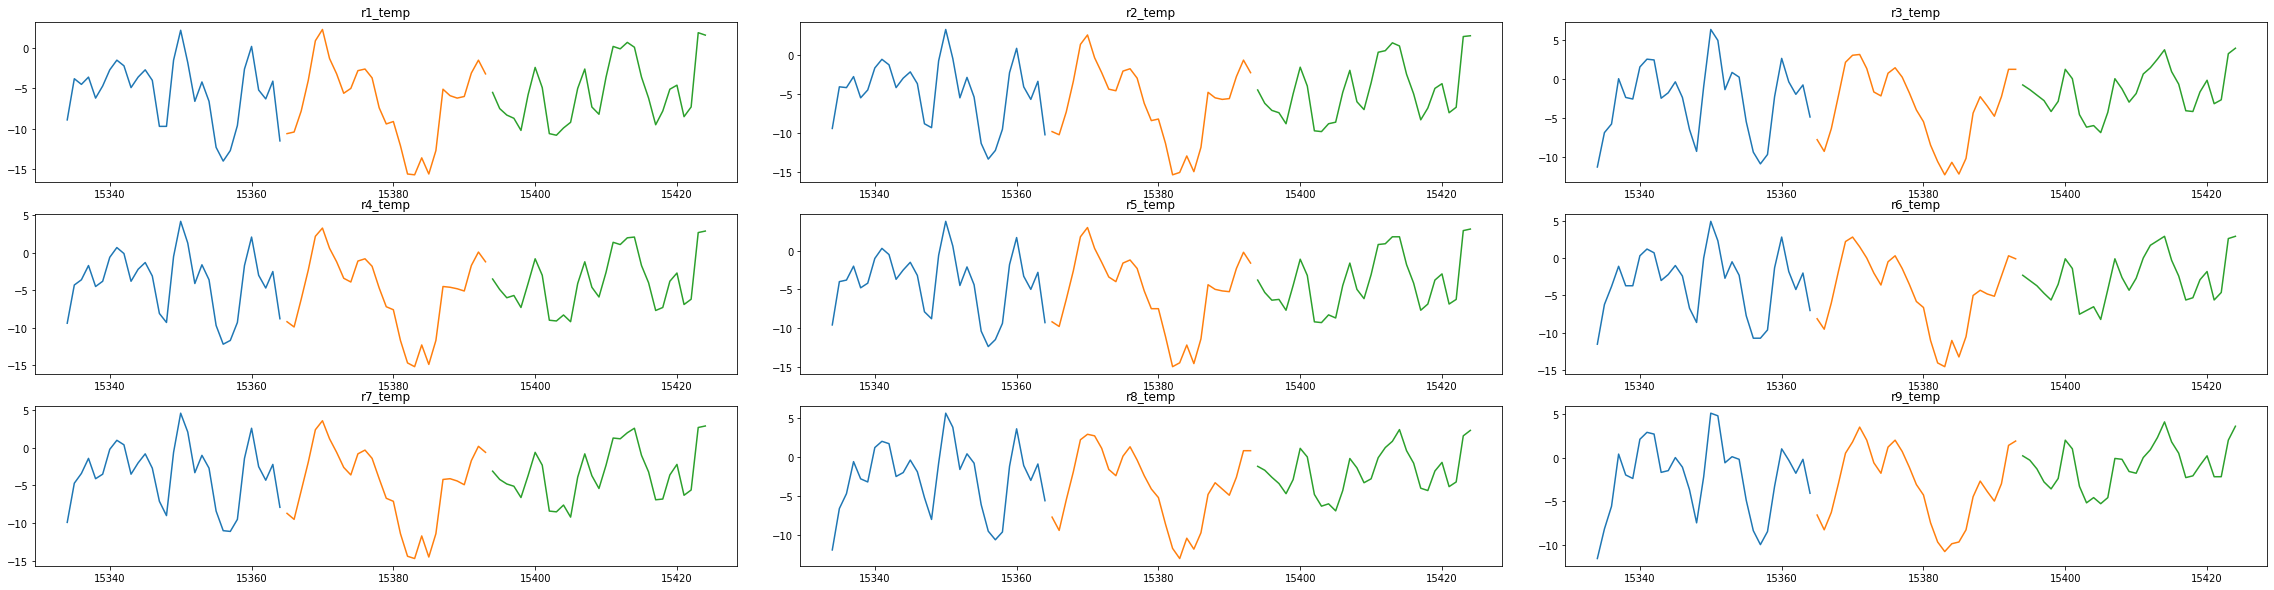

In [27]:
plot_seasonal_time_series(df, "Winter", 2000, "Temp")

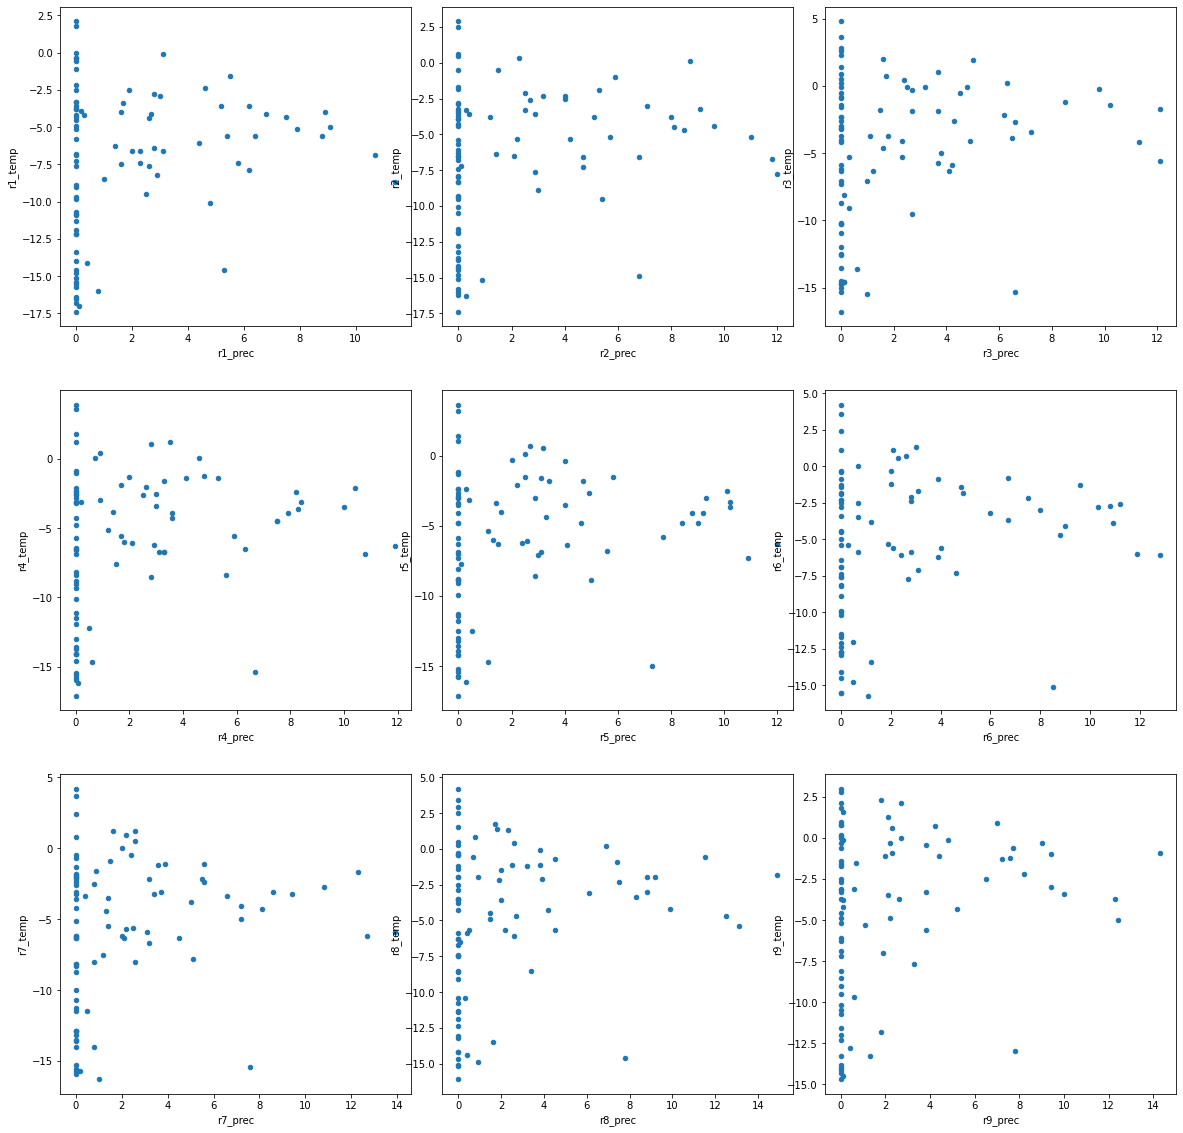

In [28]:
plot_seasonal_scatterplot(df, "Winter", 1999)

In [33]:
df = pd.read_csv("C:/Users/herna/Documents/MMS/TDA-ClimateAI/final_db.csv")

## Time series and periodicity

### Using all data

In [42]:
x = df["date"]
y = df["r1_temp"]

fig = go.Figure(data=go.Scatter(x=x, y=y))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

In [43]:
max_embedding_dimension = 2
max_time_delay = 1000
stride = 30

embedder_periodic = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    n_jobs=2,
    stride=stride,
)

def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )

    return y_embedded

y_periodic_embedded = fit_embedder(embedder_periodic, y)

Shape of embedded time series: (697, 2)
Optimal embedding dimension is 2 and time delay is 269


In [44]:
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 269
stride = 10

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y)

plot_point_cloud(y_nonperiodic_embedded)

### Using segments

In [56]:
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence

def analyze_time_interval(data, starting_year, longitude, var, region, dimension):
    to_plot = data[(data["Year"] >= starting_year) & (data["Year"] <= starting_year+longitude)]
    temp="r"+str(region)+"_temp"
    prec="r"+str(region)+"_prec"
    to_plot = to_plot[[temp, prec, "flow", "date"]]

    if var == "temp":
        to_plot = to_plot[[temp, "date"]]
    elif var == "prec":
        to_plot = to_plot[[prec, "date"]]
    elif var == "flow":
        to_plot = to_plot[["flow", "date"]]

    x = to_plot["date"]
    y = to_plot[to_plot.columns[0]]

    fig = go.Figure(data=go.Scatter(x=x, y=y))
    fig.update_layout(xaxis_title="Tiempo", yaxis_title= var)
    fig.show()

    max_embedding_dimension = 10
    max_time_delay = 1000
    stride = 30

    embedder_periodic = SingleTakensEmbedding(
        parameters_type="search",
        time_delay=max_time_delay,
        dimension=max_embedding_dimension,
        n_jobs=2,
        stride=stride
    )

    def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
        """Fits a Takens embedder and displays optimal search parameters."""
        y_embedded = embedder.fit_transform(y)

        if verbose:
            print(f"Shape of embedded time series: {y_embedded.shape}")
            print(
                f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
            )

        return y_embedded, embedder.time_delay_

    y_periodic_embedded, TD = fit_embedder(embedder_periodic, y)

    embedding_dimension_nonperiodic = dimension
    embedding_time_delay_nonperiodic = TD
    stride = 10

    embedder_nonperiodic = SingleTakensEmbedding(
        parameters_type="fixed",
        n_jobs=2,
        time_delay=embedding_time_delay_nonperiodic,
        dimension=embedding_dimension_nonperiodic,
        stride=stride)

    y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y)
    
    return y_nonperiodic_embedded

In [57]:
example = analyze_time_interval(df, 1958, 3, "temp",9, 7)

Shape of embedded time series: (47, 2)
Optimal embedding dimension is 2 and time delay is 68


In [58]:
plot_point_cloud(example)

In [59]:
# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for nonperiodic signal")
nonperiodic_persistence.fit_transform_plot(example[None, :, :]);

Persistence diagram for nonperiodic signal


,date,flow,r1_temp,r2_temp,r3_temp,r4_temp,r5_temp,r6_temp,r7_temp,r8_temp,...,r4_prec,r5_prec,r6_prec,r7_prec,r8_prec,r9_prec,Year,Month,Day,Season
0,1958-01-04,1.723781,-12.8,-13.000000,-13.0,-12.5,-12.500000,-12.7,-12.000000,-12.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1958,1,4,Winter
1,1958-01-05,0.960882,-7.8,-7.900000,-8.4,-7.0,-7.300000,-8.6,-6.500000,-7.7,...,3.3,3.7,0.7,3.1,4.2,1.1,1958,1,5,Winter
2,1958-01-06,0.001000,-11.0,-9.900000,-6.5,-8.5,-9.000000,-7.4,-7.900000,-6.8,...,12.5,11.2,12.2,14.1,14.2,10.5,1958,1,6,Winter
3,1958-01-07,0.001000,-13.2,-12.200000,-7.9,-10.7,-11.300000,-9.8,-10.100000,-8.5,...,7.3,6.5,5.2,10.4,5.7,3.7,1958,1,7,Winter
4,1958-01-08,0.316796,-19.9,-19.299999,-15.4,-18.4,-18.700001,-16.9,-17.700001,-15.9,...,3.5,3.8,3.3,2.9,4.0,3.5,1958,1,8,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21173,2015-12-27,2.177040,-12.5,-11.700000,-8.6,-11.0,-10.900000,-9.2,-9.700000,-8.4,...,1.5,0.1,0.0,0.0,0.0,0.0,2015,12,27,Fall
21174,2015-12-28,4.876250,-12.5,-11.900000,-9.1,-11.4,-11.200000,-9.8,-10.600000,-8.6,...,6.1,3.7,5.0,5.4,0.0,5.1,2015,12,28,Fall
21175,2015-12-29,4.998840,-11.9,-11.400000,-8.4,-10.8,-10.800000,-8.6,-9.300000,-7.2,...,2.7,0.2,0.8,2.2,0.0,0.0,2015,12,29,Fall
21176,2015-12-30,4.428777,-7.0,-6.500000,-3.4,-5.9,-6.100000,-4.8,-5.000000,-3.8,...,5.1,3.5,3.4,3.2,0.0,3.6,2015,12,30,Fall
